# Pendulum on Cart System with MPC Control

In this notebook, we will simulate a pendulum on a cart system and control it using a Model Predictive Controller (MPC). The goal is to bring the pendulum from a hanging down position to an upright position.

## 1. Define the Pendulum System

First, we will define the pendulum system with friction and the given model.


In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from NonlinearMPC import NonlinearSystem

# Define the pendulum system with friction and given model
def pendulum_system():
    # Pendulum parameters
    m = 0.2
    b = 0.1
    l = 0.3
    I = 0.006
    g = 9.81

    a = m * g * l / (I + m * l**2)
    c = m * l / (I + m * l**2)

    th = ca.MX.sym("th")
    thDot = ca.MX.sym("thDot")
    u = ca.MX.sym("u")  # Control input

    states = ca.vertcat(th, thDot)
    inputs = ca.vertcat(u)

    # Pendulum dynamics with friction term
    rhs = ca.vertcat(
        thDot,                     # dth/dt
        a * ca.sin(th) + c * ca.cos(th) * u - b * thDot  # dth_dot/dt
    )

    return states, inputs, rhs

# Create the NonlinearSystem object
states, inputs, rhs = pendulum_system()
output = states  # Output is the state itself
nlsys_pendulum = NonlinearSystem(updfcn=rhs, states=states, inputs=inputs, outfcn=output)

# Discretize the system
dt = 0.1
nlsys_pendulum_discrete = nlsys_pendulum.c2d(dt)


## 2. Define the MPC Problem

Next, we will define the MPC problem data, including the prediction model, cost matrices, horizon, and input/output constraints.


In [2]:
# Example mpcProblemData
mpcProblemData = {
    'predictionModel': nlsys_pendulum_discrete,
    'T': 20,
    'Q': np.eye(2),
    'R': np.eye(1),
    'QT': 1000 * np.eye(2),
    'ulim': 10.0,
    'ylim': np.array([np.inf, np.inf]),  # No output constraints
    'dt': dt
}

# Initial state (pendulum hanging down)
x0 = np.array([np.pi, 0])


## 3. Define the MPC Controller Function

We define the function to compute the predicted optimal controls using the MPC framework.


In [8]:
# Define the MPC controller function
def computePredictedOptimalControls(mpcProblemData, x0):
    predictionModel = mpcProblemData['predictionModel']
    f = predictionModel.updfcn; g = predictionModel.outfcn
    n = predictionModel.n; m = predictionModel.m

    # Extract cost matrice and horizon
    Q = mpcProblemData['Q']; R = mpcProblemData['R']; QT = mpcProblemData['QT']
    T = mpcProblemData['T']

    # Extract constraint bounds
    ulim = mpcProblemData['ulim']; ylim = mpcProblemData['ylim']

    # Setup optimization problem and define variables
    opti = ca.Opti()
    X = opti.variable(n, T+1); U = opti.variable(m, T)

    # Define initial state constraint, cost, input/output constraints
    cost = 0
    opti.subject_to(X[:, 0] == x0)
    for t in range(T):
        cost += ca.mtimes([X[:, t].T, Q, X[:, t]])
        cost += ca.mtimes([U[:, t].T, R, U[:, t]])
        opti.subject_to(X[:, t+1] == f(X[:, t], U[:, t]))
        opti.subject_to(opti.bounded(-ylim, g(X[:, t], U[:, t]), ylim))
        opti.subject_to(opti.bounded(-ulim, U[:, t], ulim))
    cost += ca.mtimes([X[:, T].T, QT, X[:, T]])
    opti.minimize(cost)

    # Pick solver (and options), solve problem, and return solution
    opti.solver('ipopt', {"ipopt": {"max_iter": 1000, "print_level": 0}})
    sol = opti.solve()
    return sol.value(X), sol.value(U)

def mpcController(mpcProblemData, x):
    x_sol, u_sol = computePredictedOptimalControls(mpcProblemData, x)
    return u_sol[0]

## 4. Simulate the System with MPC Control

Next, we simulate the pendulum system with the MPC controller to bring it from hanging down to standing up.


In [9]:
# Simulation parameters
Tsim = 10.0  # Total simulation time
N_steps = int(Tsim / dt)
time = np.linspace(0, Tsim, N_steps + 1)

# Initialize arrays to store the simulation results
x_sim = np.zeros((2, N_steps + 1))
u_sim = np.zeros(N_steps)

# Set initial state
x_sim[:, 0] = x0

# Simulation loop
for k in range(N_steps):
    # Compute the control input using MPC
    u_sim[k] = mpcController(mpcProblemData, x_sim[:, k])
    
    # Apply the control input to the system
    x_sim[:, k + 1] = nlsys_pendulum_discrete.updfcn(x_sim[:, k], u_sim[k]).full().flatten()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.86ms (  6.21us)   4.84ms (  6.19us)       783
       nlp_g  |  32.31ms ( 41.16us)  31.80ms ( 40.51us)       785
  nlp_grad_f  |   1.44ms ( 10.32us)   1.42ms ( 10.22us)       139
  nlp_hess_l  |  84.49ms (339.33us)  84.21ms (338.19us)       249
   nlp_jac_g  |  48.36ms (186.71us)  48.21ms (186.16us)       259
       total  | 443.08ms (443.08ms) 441.65ms (441.65ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.05ms (  6.22us)   5.02ms (  6.18us)       812
       nlp_g  |  33.63ms ( 41.37us)  33.20ms ( 40.83us)       813
  nlp_grad_f  |   2.35ms (  9.61us)   2.31ms (  9.45us)       244
  nlp_hess_l  | 106.37ms (335.56us) 106.25ms (335.17us)       317
   nlp_jac_g  |  61.03ms (183.82us)  61.06ms (183.91us)       332
       total  | 513.86ms (513.86ms) 513.33ms (513.33ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  75.00us ( 10.71us)  66.33us (  9.48us)         7
       nlp_g  | 322.00us ( 46.00us) 309.74us ( 44.25us)         7
  nlp_grad_f  | 138.00us ( 17.25us) 138.17us ( 17.27us)         8
  nlp_hess_l  |   2.26ms (376.17us)   2.26ms (376.30us)         6
   nlp_jac_g  |   1.67ms (208.38us)   1.67ms (209.08us)         8
       total  |   9.46ms (  9.46ms)   9.44ms (  9.44ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  56.00us (  8.00us)  53.98us (  7.71us)         7
       nlp_g  | 313.00us ( 44.71us) 298.26us ( 42.61us)         7
  nlp_grad_f  |  93.00us ( 11.62us)  93.15us ( 11.64us)         8
  nlp_hess_l  |   2.06ms (343.83us)   2.06ms (342.80us)         6
   nlp_jac_g  |   1.50ms (187.00us)   1.50ms (187.77us)         8
       total  |  10.70ms ( 10.70ms)  10.78ms ( 10.78ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  41.00us (  6.83us)  40.88us (  6.81us)         6
       nlp_g  | 248.00us ( 41.33us) 244.53us ( 40.76us)         6
  nlp_grad_f  |  69.00us (  9.86us)  71.82us ( 10.26us)         7
  nlp_hess_l  |   1.66ms (332.60us)   1.66ms (332.60us)         5
   nlp_jac_g  |   1.28ms (182.57us)   1.28ms (182.70us)         7
       total  |   8.83ms (  8.83ms)   8.82ms (  8.82ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  41.00us (  6.83us)  41.01us (  6.84us)         6
       nlp_g  | 246.00us ( 41.00us) 242.80us ( 40.47us)         6
  nlp_grad_f  |  73.00us ( 10.43us)  73.98us ( 10.57us)         7
  nlp_hess_l  |   1.64ms (328.20us)   1.64ms (328.40us)         5
   nlp_jac_g  |   1.26ms (180.57us)   1.27ms (181.06us)         7
       total  |   7.58ms (  7.58ms)   7.57ms (  7.57ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  43.00us (  7.17us)  40.35us (  6.73us)         6
       nlp_g  | 246.00us ( 41.00us) 238.66us ( 39.78us)         6
  nlp_grad_f  |  71.00us ( 10.14us)  69.87us (  9.98us)         7
  nlp_hess_l  |   1.64ms (327.40us)   1.63ms (326.37us)         5
   nlp_jac_g  |   1.24ms (177.57us)   1.24ms (177.77us)         7
       total  |   8.38ms (  8.38ms)   8.36ms (  8.36ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  42.00us (  7.00us)  41.61us (  6.94us)         6
       nlp_g  | 245.00us ( 40.83us) 241.76us ( 40.29us)         6
  nlp_grad_f  |  75.00us ( 10.71us)  72.29us ( 10.33us)         7
  nlp_hess_l  |   1.63ms (326.60us)   1.63ms (325.53us)         5
   nlp_jac_g  |   1.26ms (180.29us)   1.26ms (180.63us)         7
       total  |   8.49ms (  8.49ms)   8.48ms (  8.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  48.00us (  8.00us)  44.15us (  7.36us)         6
       nlp_g  | 245.00us ( 40.83us) 244.15us ( 40.69us)         6
  nlp_grad_f  |  75.00us ( 10.71us)  72.96us ( 10.42us)         7
  nlp_hess_l  |   1.67ms (333.00us)   1.66ms (331.76us)         5
   nlp_jac_g  |   1.36ms (193.86us)   1.35ms (193.52us)         7
       total  |   8.60ms (  8.60ms)   8.59ms (  8.59ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  78.00us ( 13.00us)  73.18us ( 12.20us)         6
       nlp_g  | 269.00us ( 44.83us) 267.49us ( 44.58us)         6
  nlp_grad_f  |  85.00us ( 12.14us)  83.50us ( 11.93us)         7
  nlp_hess_l  |   1.90ms (380.60us)   1.95ms (389.84us)         5
   nlp_jac_g  |   1.38ms (196.71us)   1.37ms (195.83us)         7
       total  |   9.16ms (  9.16ms)   9.19ms (  9.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

## 5. Plot the results

Finally, we plot the results.


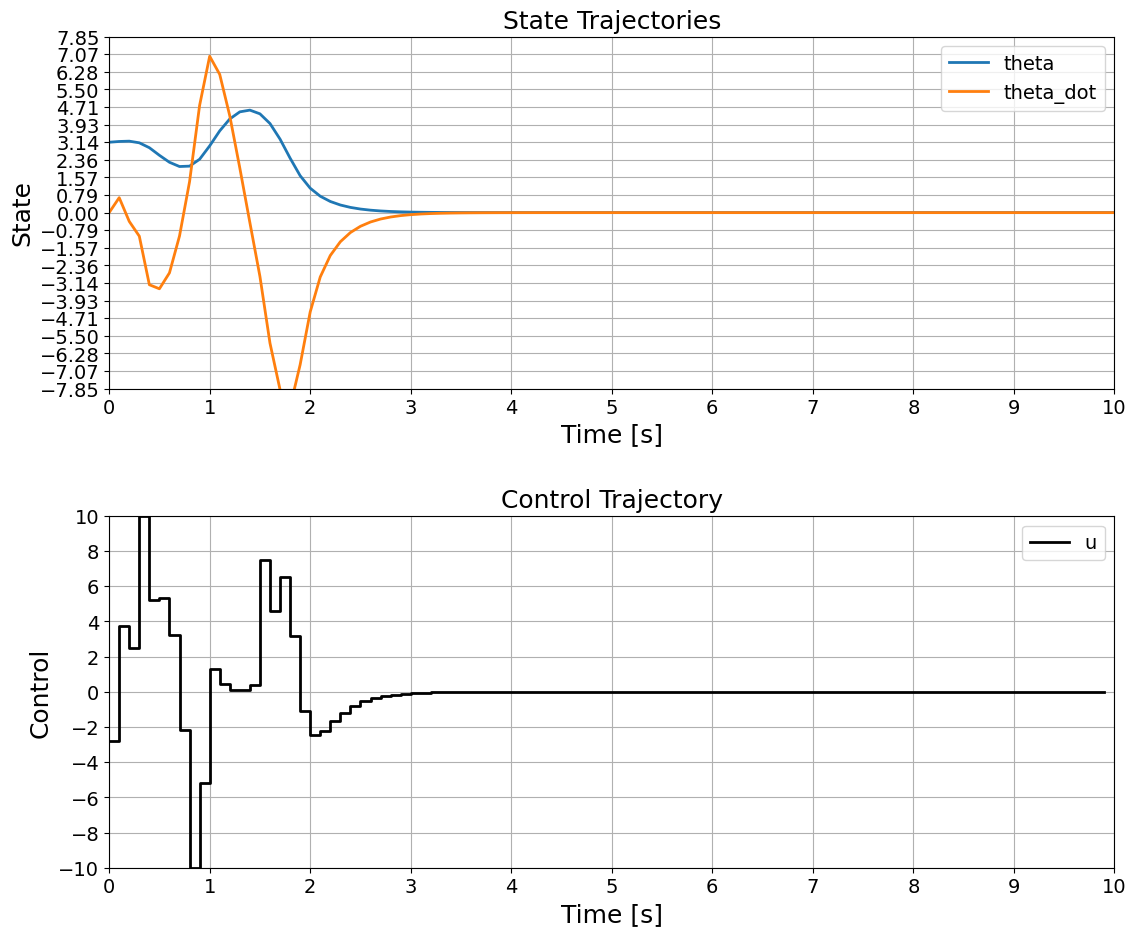

In [10]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the state trajectories on the first subplot
ax1.plot(time, x_sim[0, :], label='theta', linewidth=2)
ax1.plot(time, x_sim[1, :], label='theta_dot', linewidth=2)
ax1.set_xlabel('Time [s]', fontsize=18)
ax1.set_ylabel('State', fontsize=18)
ax1.set_xlim([0, Tsim])
ax1.set_ylim([-2.5 * np.pi, 2.5 * np.pi])
ax1.legend(fontsize=14)
ax1.set_title('State Trajectories', fontsize=18)
ax1.grid(True)

# Set grid steps
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(np.pi / 4))

# Plot the control trajectory on the second subplot
ax2.step(time[:-1], u_sim, 'k', label='u', where='post', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=18)
ax2.set_ylabel('Control', fontsize=18)
ax2.set_xlim([0, Tsim])
ax2.set_ylim([-10, 10])
ax2.legend(fontsize=14)
ax2.set_title('Control Trajectory', fontsize=18)
ax2.grid(True)

# Set grid steps
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Set tick font size
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout to make space for larger labels
plt.tight_layout(pad=3.0)

# Save the plot as a PDF file
plt.savefig('Figures/mpc_simulation_pendulum.pdf', format='pdf')

# Show the plots
plt.show()